In [381]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV
import xgboost as xgb
from sklearn.metrics import mean_absolute_error, mean_squared_error 
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, GRU, Dense, Dropout
from tensorflow.keras.optimizers import Adam


In [382]:
def data_preprocessing_stocks(data):
    # Ensure Datetime is parsed (if not already)
    data["Datetime"] = pd.to_datetime(data["Datetime"])
    
    # Drop non-feature columns.
    data = data.drop(columns=["Ticker", "Datetime"])
    
    # Define features (X) and target (y)
    X = data.drop(columns=["Close"])
    y = data["Close"]
    
    return X, y



In [383]:
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

def remove_nan_inf(X, y):
    """ Removes NaN and Inf values from X and y. """
    mask = np.isnan(X).any(axis=1) | np.isnan(y) | np.isinf(X).any(axis=1) | np.isinf(y)
    X_clean, y_clean = X[~mask], y[~mask]
    return X_clean, y_clean

def create_sequences(X, y, timesteps):
    """ Converts data into 3D sequences for RNN training. """
    X_seq, y_seq = [], []
    for i in range(len(X) - timesteps):
        X_seq.append(X[i : i + timesteps])
        y_seq.append(y[i + timesteps])  
    return np.array(X_seq), np.array(y_seq)

def scaling_train_test_split(X, y, timesteps=20):
    """
    Splits and scales data for RNNs, ensuring both X and y are properly scaled.

    Parameters:
    - X: Feature matrix (samples, features)
    - y: Target values
    - timesteps: Number of past observations to include for each sample

    Returns:
    - X_train_seq: 3D NumPy array (samples, timesteps, features)
    - X_test_seq: 3D NumPy array (samples, timesteps, features)
    - y_train_seq: 1D or 2D target array
    - y_test_seq: 1D or 2D target array
    - scaler_X: StandardScaler for `X`
    - scaler_y: StandardScaler for `y`
    """

    # Train-test split (shuffle=False to maintain time order)
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, shuffle=False)

    # Remove NaN and Inf values
    X_train, y_train = remove_nan_inf(X_train, y_train)
    X_test, y_test = remove_nan_inf(X_test, y_test)

    # Scale features and target
    scaler_X = StandardScaler()
    scaler_y = StandardScaler()

    X_train_scaled = scaler_X.fit_transform(X_train)
    X_test_scaled = scaler_X.transform(X_test)

    y_train_scaled = scaler_y.fit_transform(y_train.to_numpy().reshape(-1, 1)).flatten()
    y_test_scaled = scaler_y.transform(y_test.to_numpy().reshape(-1, 1)).flatten()


    # Convert to 3D sequences
    X_train_seq, y_train_seq = create_sequences(X_train_scaled, y_train_scaled, timesteps)
    X_test_seq, y_test_seq = create_sequences(X_test_scaled, y_test_scaled, timesteps)

    return X_train_seq, X_test_seq, y_train_seq, y_test_seq, scaler_X, scaler_y  # 🚀 Return both scalers


In [ ]:
def train_rnn_model(X_train, y_train, architecture="LSTM", units=50, dropout_rate=0.2, 
                    learning_rate=0.001, epochs=50, batch_size=32, verbose=1):
    
    # Check input dimensions
    assert len(X_train.shape) == 3, "X_train must be a 3D array (samples, timesteps, features)"
    
    # Define RNN model
    model = Sequential()
    
    model.add(LSTM(units=units, return_sequences=True, input_shape=(X_train.shape[1], X_train.shape[2])))
    model.add(Dropout(dropout_rate))
    model.add(LSTM(units=units, return_sequences=False))

    # Output layer
    model.add(Dense(units=1))  # For regression tasks

    # Compile model
    model.compile(optimizer=Adam(learning_rate=learning_rate), loss='mse', metrics=['mae'])

    # Train the model
    print(f"Training {architecture} model with {X_train.shape[0]} samples...")
    model.fit(X_train, y_train, epochs=epochs, batch_size=batch_size, verbose=verbose)

    print("Model training complete.")
    
    return model

In [385]:
import keras_tuner as kt
import tensorflow as tf

def randomized_search_rnn(X_train, y_train, X_val, y_val, build_rnn_model, ticker_symbol, 
                          max_trials=10, executions_per_trial=1, epochs=50, batch_size=32):
   

    tuner = kt.RandomSearch(
        build_rnn_model,  # Function to build the model
        objective="val_loss",
        max_trials=max_trials,
        executions_per_trial=executions_per_trial,
        directory="rnn_tuning",
        project_name=f"rnn_random_search_{ticker_symbol}"
    )

    # Early stopping to prevent overfitting
    early_stopping = tf.keras.callbacks.EarlyStopping(monitor="val_loss", patience=5, restore_best_weights=True)

    # Perform the search
    tuner.search(
        X_train, y_train,
        validation_data=(X_val, y_val),  # Use explicit validation set instead of validation_split
        epochs=epochs,
        batch_size=batch_size,
        callbacks=[early_stopping],
        verbose=1
    )

    # Get the best hyperparameters
    best_hps = tuner.get_best_hyperparameters(num_trials=1)[0]
    best_model = tuner.get_best_models(num_models=1)[0]

    # Print best hyperparameters
    print(f"\n✅ Best Hyperparameters for {ticker_symbol}: {best_hps.values}")

    # Save the best model
    best_model.save(f"best_rnn_model_{ticker_symbol}.h5")
    print(f"📌 Best RNN model for {ticker_symbol} saved as 'best_rnn_model_{ticker_symbol}.h5'")

    # Return the best model and hyperparameters
    return best_model, best_hps



In [386]:
def evaluate_rnn_model(X_train_seq, X_test_seq, y_train, y_test, rnn_model, ticker_symbol):
    """
    Evaluates the RNN model's performance on training and test data.
    
    Parameters:
    - X_train_seq: 3D NumPy array (samples, timesteps, features) for training
    - X_test_seq: 3D NumPy array (samples, timesteps, features) for testing
    - y_train: Training target values
    - y_test: Testing target values
    - rnn_model: Trained RNN model (LSTM/GRU)
    - currency: Name of the currency (e.g., "USD")
    - ticker_symbol: Stock ticker symbol (e.g., "AAPL")
    
    Returns:
    - y_pred: Predicted values for the test set
    """
    # Make predictions
    y_pred = rnn_model.predict(X_test_seq)

    # Compute Train and Test Scores (R² Score for consistency with XGBoost)
    train_score = rnn_model.evaluate(X_train_seq, y_train, verbose=0)[1]  # Mean Absolute Error (MAE)
    test_score = rnn_model.evaluate(X_test_seq, y_test, verbose=0)[1]  # MAE for testing

    # Print Scores in Requested Format
    print(f"Train score for {ticker_symbol}: {train_score:.4f}")
    print(f"Test score for {ticker_symbol}: {test_score:.4f}")

    return y_pred


In [387]:
def plot_comparison(y_test, y_pred, currency):
    # Plot actual vs. predicted values
    plt.figure(figsize=(10, 5))
    plt.plot(y_test, label="Actual", linestyle="-", marker="o", alpha=0.7)  
    plt.plot(y_pred, label="Predicted", linestyle="-", marker="x", alpha=0.7)

    plt.xlabel("Time (minutes)")
    plt.ylabel("Closing Price (USD)")
    plt.title(f"Actual vs. Predicted Closing Prices  - {currency}")
    plt.legend()
    plt.grid(True)
    plt.show()

In [388]:
def next_minute_price(X, y, model, ticker, timesteps=10):
    """
    Predicts the next minute's closing price using an RNN model.
    
    Parameters:
    - X: 3D NumPy array or Pandas DataFrame (features)
    - y: Pandas Series or NumPy array (actual prices)
    - model: Trained RNN model
    - ticker: Stock ticker symbol (e.g., "AAPL", "TSLA")
    - timesteps: Number of past time steps used in prediction
    
    Prints:
    - The predicted next price and whether it will increase or decrease.
    """

    # Convert X to a proper 3D shape: (1, timesteps, features)
    if isinstance(X, np.ndarray):
        last_sequence = X[-timesteps:].reshape(1, timesteps, X.shape[2])
    else:  # If X is a Pandas DataFrame
        last_sequence = X.iloc[-timesteps:].to_numpy().reshape(1, timesteps, X.shape[1])

    # Predict next minute's price
    next_price = model.predict(last_sequence)[0][0]  # Extract single value

    # Get the last known actual price
    last_actual_price = y.iloc[-1].item()  # Ensure it's a scalar value

    # Compare and print result
    if next_price > last_actual_price:
        print(f"{ticker}: 📈 The price will increase from ${last_actual_price:.4f} to ${next_price:.4f}")
    elif next_price < last_actual_price:
        print(f"{ticker}: 📉 The price will decrease from ${last_actual_price:.4f} to ${next_price:.4f}")
    else:
        print(f"{ticker}: ➖ No significant change expected: ${next_price:.4f}")
    
    return next_price

1. Training with Indicators. 


In [389]:
# Load the datasets
df_prices = pd.read_csv('stock_prices_2m_with_indicators.csv', parse_dates=["Datetime"]) 
tickers = ["AAPL", "TSLA", "GOOGL", "AMZN", "NVDA", "META", "MSFT"]
df_AAPL  = df_prices[df_prices["Ticker"] == "AAPL"].copy()
df_TSLA  = df_prices[df_prices["Ticker"] == "TSLA"].copy()
df_GOOGL = df_prices[df_prices["Ticker"] == "GOOGL"].copy()
df_AMZN  = df_prices[df_prices["Ticker"] == "AMZN"].copy()
df_NVDA  = df_prices[df_prices["Ticker"] == "NVDA"].copy()
df_META  = df_prices[df_prices["Ticker"] == "META"].copy()
df_MSFT  = df_prices[df_prices["Ticker"] == "MSFT"].copy()

In [390]:
X_AAPL, y_AAPL = data_preprocessing_stocks(df_AAPL)
X_TSLA, y_TSLA = data_preprocessing_stocks(df_TSLA)
X_GOOGL, y_GOOGL = data_preprocessing_stocks(df_GOOGL)
X_AMZN, y_AMZN = data_preprocessing_stocks(df_AMZN)
X_NVDA, y_NVDA = data_preprocessing_stocks(df_NVDA)
X_META, y_META = data_preprocessing_stocks(df_META)
X_MSFT, y_MSFT = data_preprocessing_stocks(df_MSFT)


In [391]:
# For AAPL
X_train_AAPL, X_test_AAPL, y_train_AAPL, y_test_AAPL, scaler_x_AAPL, scaler_y_AAPL = scaling_train_test_split(X_AAPL, y_AAPL)

# For TSLA
X_train_TSLA, X_test_TSLA, y_train_TSLA, y_test_TSLA, scaler_x_TSLA, scaler_y_TSLA = scaling_train_test_split(X_TSLA, y_TSLA)

# For GOOGL
X_train_GOOGL, X_test_GOOGL, y_train_GOOGL, y_test_GOOGL, scaler_x_GOOGL, scaler_y_GOOGL = scaling_train_test_split(X_GOOGL, y_GOOGL)

# For AMZN
X_train_AMZN, X_test_AMZN, y_train_AMZN, y_test_AMZN, scaler_x_AMZN, scaler_y_AMZN= scaling_train_test_split(X_AMZN, y_AMZN)

# For NVDA
X_train_NVDA, X_test_NVDA, y_train_NVDA, y_test_NVDA, scaler_x_NVDA, scaler_y_NVDA = scaling_train_test_split(X_NVDA, y_NVDA)

# For META
X_train_META, X_test_META, y_train_META, y_test_META, scaler_x_META, scaler_y_META = scaling_train_test_split(X_META, y_META)

# For MSFT
X_train_MSFT, X_test_MSFT, y_train_MSFT, y_test_MSFT, scaler_x_MSFT, scaler_y_MSFT = scaling_train_test_split(X_MSFT, y_MSFT)


In [392]:
aapl_model  = train_rnn_model(X_train_AAPL, y_train_AAPL)
tsla_model  = train_rnn_model(X_train_TSLA, y_train_TSLA)
googl_model = train_rnn_model(X_train_GOOGL, y_train_GOOGL)
amzn_model  = train_rnn_model(X_train_AMZN, y_train_AMZN)
nvda_model  = train_rnn_model(X_train_NVDA, y_train_NVDA)
meta_model  = train_rnn_model(X_train_META, y_train_META)
msft_model  = train_rnn_model(X_train_MSFT, y_train_MSFT)


Training LSTM model with 5124 samples...
Epoch 1/50


c:\Users\ASUS\anaconda3\Lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


161/161 ━━━━━━━━━━━━━━━━━━━━ 3s 8ms/step - loss: 0.1307 - mae: 0.2387
Epoch 2/50
161/161 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 0.0136 - mae: 0.0854
Epoch 3/50
161/161 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.0100 - mae: 0.0741
Epoch 4/50
161/161 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 0.0087 - mae: 0.0689
Epoch 5/50
161/161 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.0081 - mae: 0.0656
Epoch 6/50
161/161 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.0078 - mae: 0.0640
Epoch 7/50
161/161 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.0064 - mae: 0.0588
Epoch 8/50
161/161 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 0.0064 - mae: 0.0575
Epoch 9/50
161/161 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.0068 - mae: 0.0585
Epoch 10/50
161/161 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.0057 - mae: 0.0553
Epoch 11/50
161/161 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 0.0056 - mae: 0.0562
Epoch 12/50
161/161 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 0.0059 - mae: 0.0554
Epoch 13/50
161/161 ━━━━━━━━━━━━━━━━

In [395]:
y_pred_AAPL  = evaluate_rnn_model(X_train_AAPL,  X_test_AAPL,  y_train_AAPL,  y_test_AAPL,  aapl_model,  'AAPL')
y_pred_TSLA  = evaluate_rnn_model(X_train_TSLA,  X_test_TSLA,  y_train_TSLA,  y_test_TSLA,  tsla_model,  'TSLA')
y_pred_GOOGL = evaluate_rnn_model(X_train_GOOGL, X_test_GOOGL, y_train_GOOGL, y_test_GOOGL, googl_model, 'GOOGL')
y_pred_AMZN  = evaluate_rnn_model(X_train_AMZN,  X_test_AMZN,  y_train_AMZN,  y_test_AMZN,  amzn_model,  'AMZN')
y_pred_NVDA  = evaluate_rnn_model(X_train_NVDA,  X_test_NVDA,  y_train_NVDA,  y_test_NVDA,  nvda_model,  'NVDA')
y_pred_META  = evaluate_rnn_model(X_train_META,  X_test_META,  y_train_META,  y_test_META,  meta_model,  'META')
y_pred_MSFT  = evaluate_rnn_model(X_train_MSFT,  X_test_MSFT,  y_train_MSFT,  y_test_MSFT,  msft_model,  'MSFT')


40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
Train score for AAPL: 0.0416
Test score for AAPL: 0.5478
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
Train score for TSLA: 0.0224
Test score for TSLA: 0.3663
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
Train score for GOOGL: 0.0221
Test score for GOOGL: 0.2209
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
Train score for AMZN: 0.0296
Test score for AMZN: 0.2221
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
Train score for NVDA: 0.0330
Test score for NVDA: 0.1654
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
Train score for META: 0.0394
Test score for META: 0.4017
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
Train score for MSFT: 0.0230
Test score for MSFT: 0.1873


In [396]:
y_pred_original_AAPL = scaler_y_AAPL.inverse_transform(y_pred_scaled.reshape(-1, 1)).flatten()
y_test_original_AAPL = scaler_y_AAPL.inverse_transform(y_test.reshape(-1, 1)).flatten() 
y_pred_original_TSLA = scaler_y_TSLA.inverse_transform(y_pred_scaled.reshape(-1, 1)).flatten()
y_test_original_TSLA = scaler_y_TSLA.inverse_transform(y_test.reshape(-1, 1)).flatten() 
y_pred_original_NVDA = scaler_y_NVDA.inverse_transform(y_pred_scaled.reshape(-1, 1)).flatten()
y_test_original_NVDA = scaler_y_NVDA.inverse_transform(y_test.reshape(-1, 1)).flatten()
y_pred_original_MSFT = scaler_y_MSFT.inverse_transform(y_pred_scaled.reshape(-1, 1)).flatten()
y_test_original_MSFT = scaler_y_MSFT.inverse_transform(y_test.reshape(-1, 1)).flatten()
y_pred_original_META = scaler_y_META.inverse_transform(y_pred_scaled.reshape(-1, 1)).flatten()
y_test_original_META = scaler_y_META.inverse_transform(y_test.reshape(-1, 1)).flatten()
y_pred_original_GOOGL = scaler_y_GOOGL.inverse_transform(y_pred_scaled.reshape(-1, 1)).flatten()
y_test_original_GOOGL = scaler_y_GOOGL.inverse_transform(y_test.reshape(-1, 1)).flatten()

NameError: name 'y_pred_scaled' is not defined

In [394]:
randomized_search_rnn(X_train_AAPL, y_train_AAPL, X_test_AAPL, y_test_AAPL,'AAPL') 


TypeError: randomized_search_rnn() missing 1 required positional argument: 'ticker_symbol'

In [ ]:
randomized_search_rnn(X_train_TSLA, y_train_TSLA, X_test_TSLA, y_test_TSLA,'TSLA')  

Fitting 3 folds for each of 10 candidates, totalling 30 fits
Best Parameters: {'subsample': 0.7, 'reg_lambda': 1.0, 'reg_alpha': 0.1, 'n_estimators': 50, 'min_child_weight': 1, 'max_depth': 5, 'learning_rate': 0.2, 'gamma': 0.2, 'colsample_bytree': 1.0}
Best Cross-Validation Score (neg_mean_squared_error): -405.18994164561155
[266.38196 266.3901  268.74786 ... 264.9199  264.88824 265.22903]


In [ ]:
randomized_search_rnn(X_train_MSFT, y_train_MSFT, X_test_MSFT, y_test_MSFT,'MSFT') 

Fitting 3 folds for each of 10 candidates, totalling 30 fits
Best Parameters: {'subsample': 0.9, 'reg_lambda': 0.1, 'reg_alpha': 0.01, 'n_estimators': 200, 'min_child_weight': 1, 'max_depth': 7, 'learning_rate': 0.2, 'gamma': 0.3, 'colsample_bytree': 1.0}
Best Cross-Validation Score (neg_mean_squared_error): -112.03593633675577
[385.24432 384.91974 385.9093  ... 384.61444 384.02112 383.8754 ]


In [ ]:
randomized_search_rnn(X_train_NVDA, y_train_NVDA, X_test_NVDA, y_test_NVDA,'NVDA') 

Fitting 3 folds for each of 10 candidates, totalling 30 fits
Best Parameters: {'subsample': 0.7, 'reg_lambda': 1.0, 'reg_alpha': 0.1, 'n_estimators': 50, 'min_child_weight': 1, 'max_depth': 5, 'learning_rate': 0.2, 'gamma': 0.2, 'colsample_bytree': 1.0}
Best Cross-Validation Score (neg_mean_squared_error): -0.5303823601296167
[114.24504  114.06854  114.810165 ... 115.47884  115.71722  115.40932 ]


In [ ]:
randomized_search_rnn(X_train_AMZN, y_train_AMZN, X_test_AMZN, y_test_AMZN,'AMZN') 

Fitting 3 folds for each of 10 candidates, totalling 30 fits
Best Parameters: {'subsample': 0.9, 'reg_lambda': 0.1, 'reg_alpha': 0.01, 'n_estimators': 200, 'min_child_weight': 1, 'max_depth': 7, 'learning_rate': 0.2, 'gamma': 0.3, 'colsample_bytree': 1.0}
Best Cross-Validation Score (neg_mean_squared_error): -49.393185244389294
[201.26324 201.50055 201.73582 ... 199.42079 200.12189 199.97423]


In [ ]:
randomized_search_rnn(X_train_META, y_train_META, X_test_META, y_test_META,'META') 

Fitting 3 folds for each of 10 candidates, totalling 30 fits
Best Parameters: {'subsample': 1.0, 'reg_lambda': 0.1, 'reg_alpha': 0.1, 'n_estimators': 100, 'min_child_weight': 1, 'max_depth': 3, 'learning_rate': 0.1, 'gamma': 0, 'colsample_bytree': 0.9}
Best Cross-Validation Score (neg_mean_squared_error): -38.267056637515935
[629.9248  628.71136 631.09076 ... 627.43555 626.6066  627.2228 ]


In [ ]:
next_minute_price(X_AAPL, y_AAPL, aapl_model, 'AAPL')
next_minute_price(X_TSLA, y_TSLA, tsla_model, 'TSLA')
next_minute_price(X_GOOGL, y_GOOGL, googl_model, 'GOOGL')
next_minute_price(X_AMZN, y_AMZN, amzn_model, 'AMZN')
next_minute_price(X_NVDA, y_NVDA, nvda_model, 'NVDA')
next_minute_price(X_META, y_META, meta_model, 'META')
next_minute_price(X_MSFT, y_MSFT, msft_model, 'MSFT')


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 198ms/step
AAPL: 📉 The price will decrease from $216.9400 to $0.7660
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 200ms/step
TSLA: 📉 The price will decrease from $248.2800 to $-0.9092
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 184ms/step
GOOGL: 📉 The price will decrease from $167.0800 to $-0.0905
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 183ms/step
AMZN: 📉 The price will decrease from $198.8900 to $-0.0742
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 194ms/step
NVDA: 📉 The price will decrease from $115.7400 to $-0.8954
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 200ms/step
META: 📉 The price will decrease from $619.3400 to $0.3991
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 204ms/step
MSFT: 📉 The price will decrease from $383.2800 to $-0.2528


-0.25275102

<Axes: title={'center': 'Feature importance'}, xlabel='F score', ylabel='Features'>

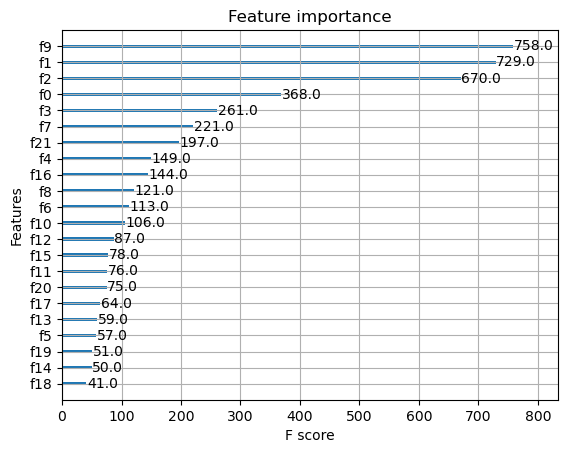

In [ ]:
xgb.plot_importance(aapl_model)

<Axes: title={'center': 'Feature importance'}, xlabel='F score', ylabel='Features'>

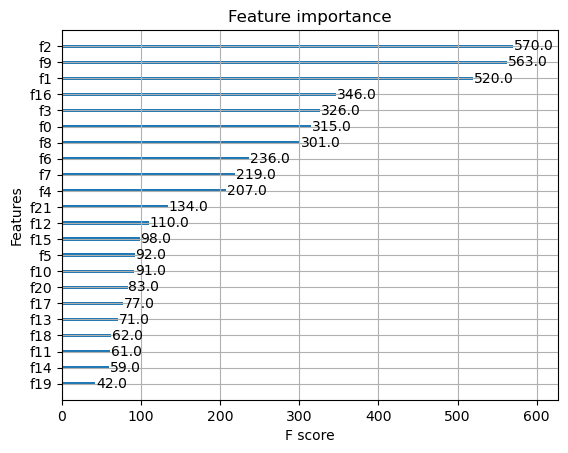

In [ ]:
xgb.plot_importance(tsla_model)

<Axes: title={'center': 'Feature importance'}, xlabel='F score', ylabel='Features'>

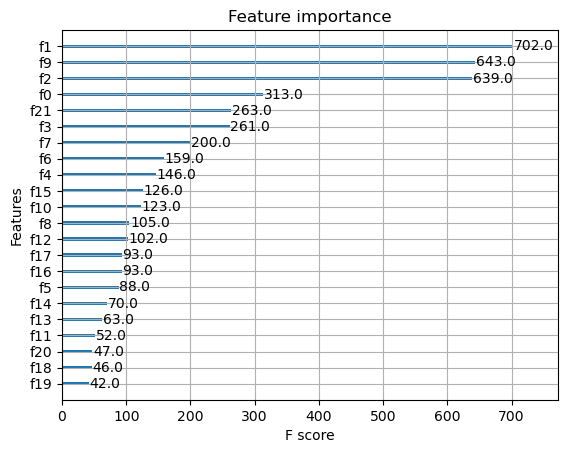

In [ ]:
xgb.plot_importance(amzn_model)

<Axes: title={'center': 'Feature importance'}, xlabel='F score', ylabel='Features'>

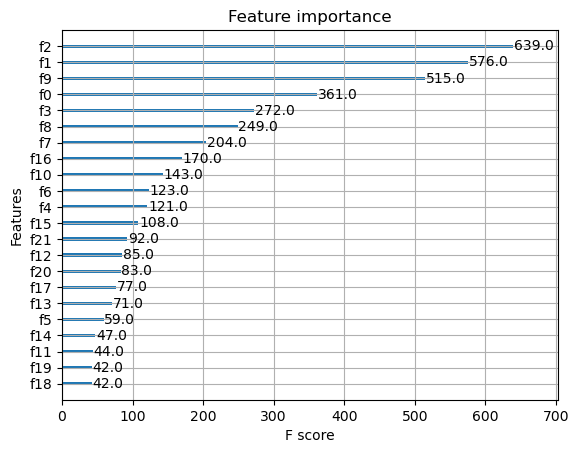

In [ ]:
xgb.plot_importance(msft_model)

<Axes: title={'center': 'Feature importance'}, xlabel='F score', ylabel='Features'>

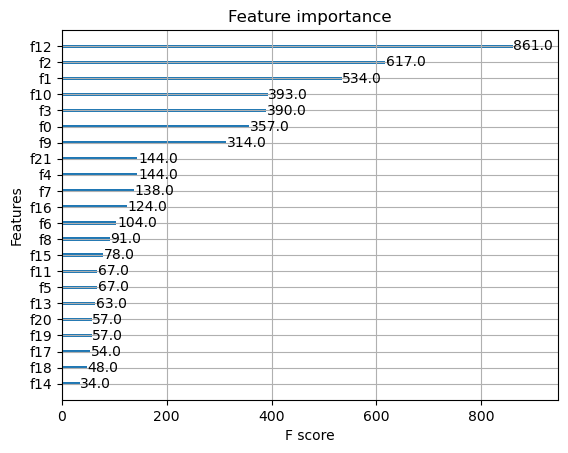

In [ ]:
xgb.plot_importance(nvda_model)

<Axes: title={'center': 'Feature importance'}, xlabel='F score', ylabel='Features'>

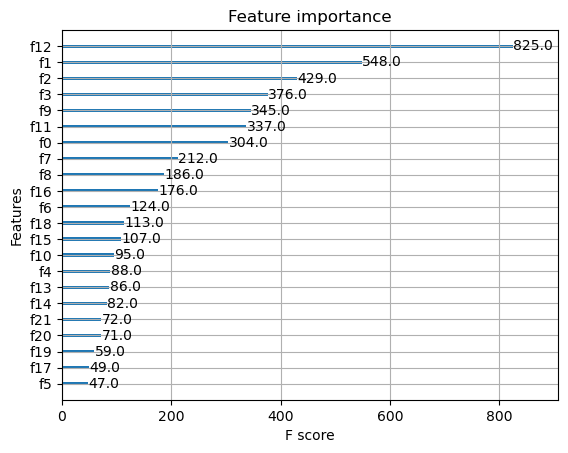

In [ ]:
xgb.plot_importance(meta_model)

<Axes: title={'center': 'Feature importance'}, xlabel='F score', ylabel='Features'>

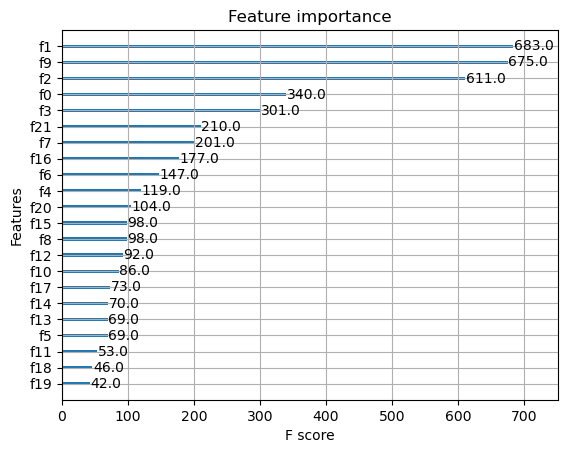

In [ ]:
xgb.plot_importance(googl_model)

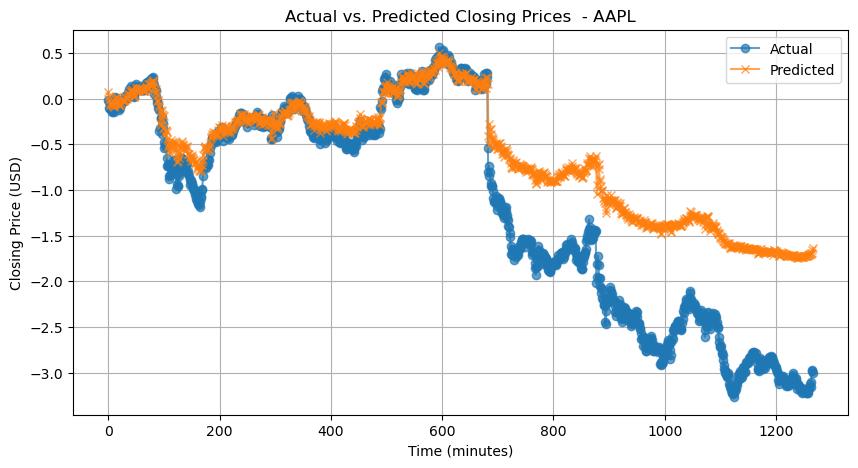

In [398]:
plot_comparison(y_test_AAPL, y_pred_AAPL, 'AAPL')

In [ ]:
y_test_AAPL

array([-0.01164634, -0.04234002, -0.10372514, ..., -2.97714654,
       -2.96983831, -3.0034535 ])

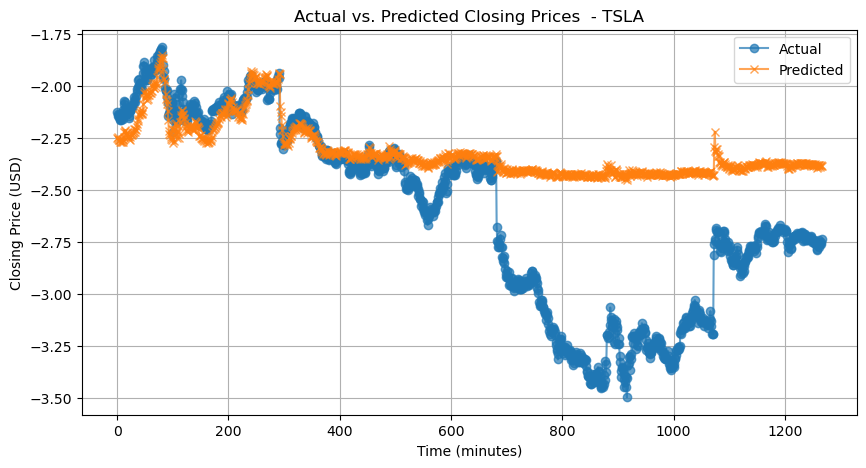

In [ ]:
plot_comparison(y_test_TSLA, y_pred_TSLA, 'TSLA')


In [ ]:
data = pd.DataFrame(y_test_GOOGL) 
data

,0
0,-1.538989
1,-1.547579
2,-1.527536
3,-1.528490
4,-1.538035
...,...
1261,-1.890236
1262,-1.870191
1263,-1.835352
1264,-1.859692


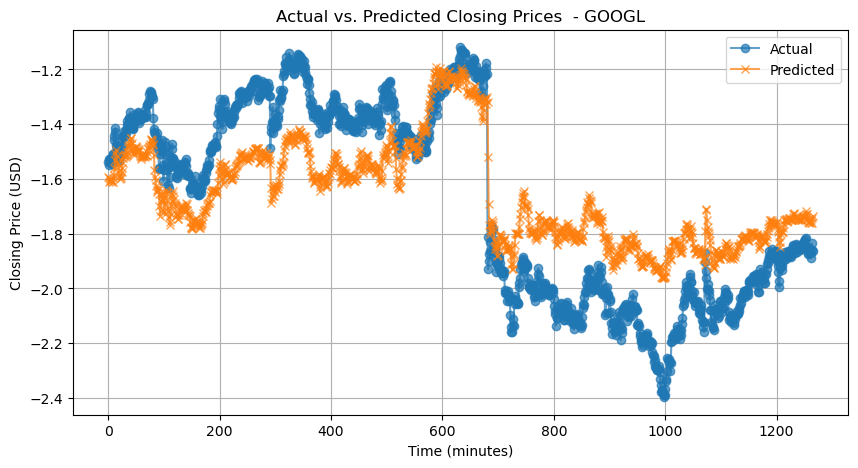

In [ ]:
plot_comparison(y_test_GOOGL, y_pred_GOOGL, 'GOOGL')


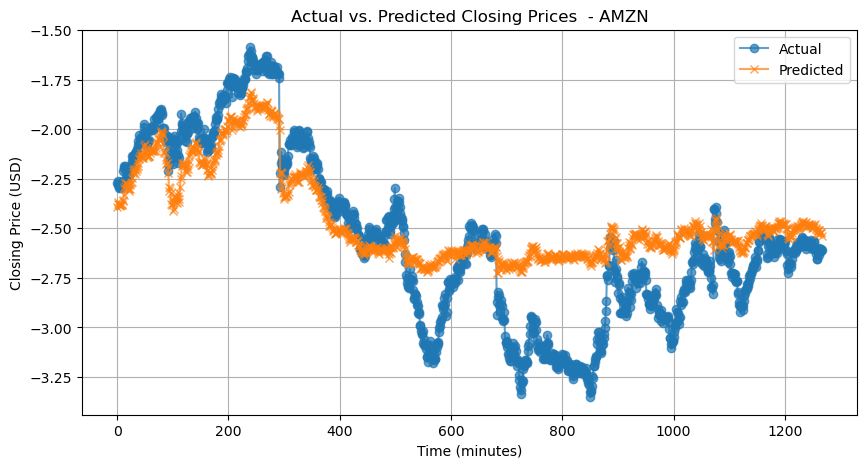

In [ ]:
plot_comparison(y_test_AMZN, y_pred_AMZN, 'AMZN')


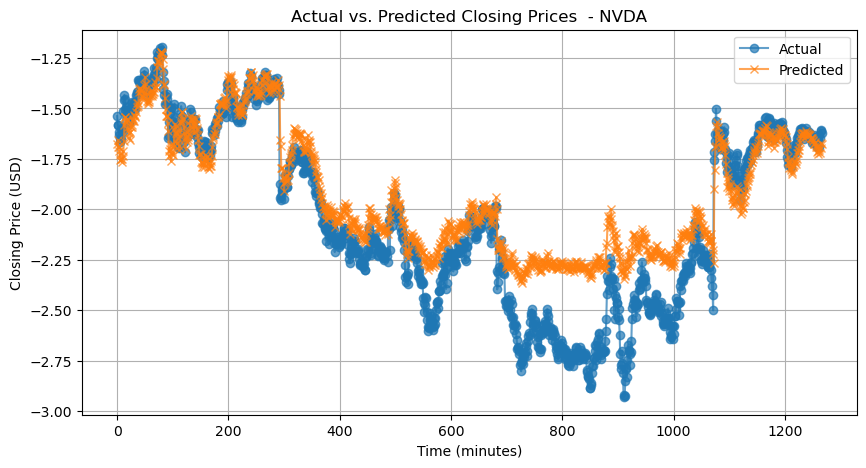

In [ ]:
plot_comparison(y_test_NVDA, y_pred_NVDA, 'NVDA')


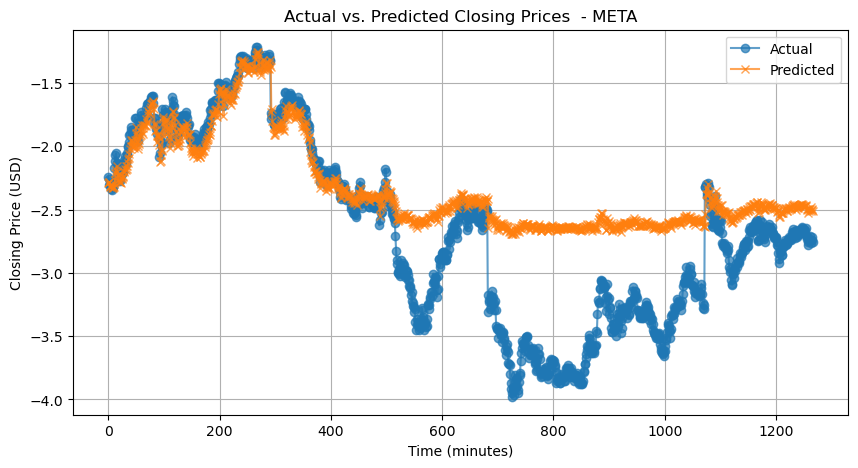

In [ ]:
plot_comparison(y_test_META, y_pred_META, 'META')


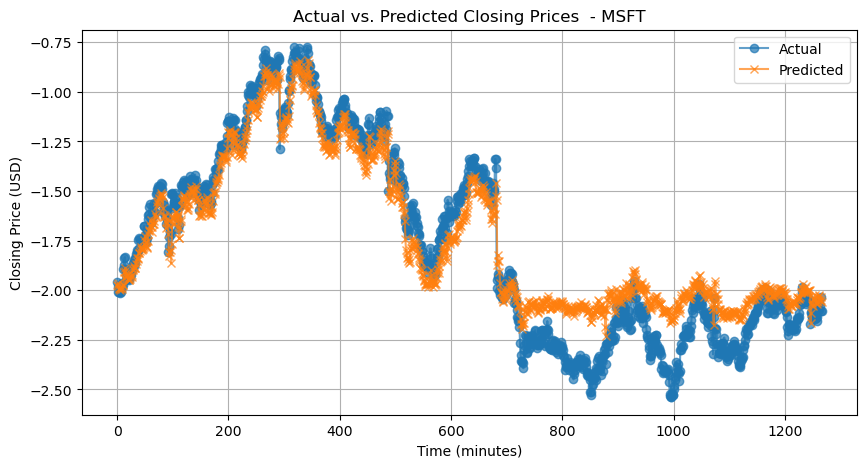

In [ ]:
plot_comparison(y_test_MSFT, y_pred_MSFT, 'MSFT')